In [2]:
import pandas as pd
spam_df = pd.read_csv("C:/Users/My-Asus/Downloads/spam.csv")
spam_df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
spam_df = spam_df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])

In [5]:
spam_df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
category = pd.get_dummies(spam_df.v1)
df_baru = pd.concat([spam_df, category], axis=1)
df_baru = df_baru.drop(columns='v1')
df_baru

,v2,ham,spam
0,"Go until jurong point, crazy.. Available only ...",1,0
1,Ok lar... Joking wif u oni...,1,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,0,1
3,U dun say so early hor... U c already then say...,1,0
4,"Nah I don't think he goes to usf, he lives aro...",1,0
...,...,...,...
5567,This is the 2nd time we have tried 2 contact u...,0,1
5568,Will �_ b going to esplanade fr home?,1,0
5569,"Pity, * was in mood for that. So...any other s...",1,0
5570,The guy did some bitching but I acted like i'd...,1,0


In [11]:
df_baru.isnull().sum()

v2      0
ham     0
spam    0
dtype: int64

In [13]:
df_baru.shape

(5572, 3)

In [18]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

ps = PorterStemmer()

corpus = []

for i in range(len(df_baru)):
    review = re.sub('[^a-zA-Z]',' ',df_baru['v2'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if word not in set(stopwords.words('english'))]
    review = ' '.join(review)
    corpus.append(review)

corpus

[nltk_data] Downloading package stopwords to C:\Users\My-
[nltk_data]     Asus\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


['go jurong point crazi avail bugi n great world la e buffet cine got amor wat',
 'ok lar joke wif u oni',
 'free entri wkli comp win fa cup final tkt st may text fa receiv entri question std txt rate c appli',
 'u dun say earli hor u c alreadi say',
 'nah think goe usf live around though',
 'freemsg hey darl week word back like fun still tb ok xxx std chg send rcv',
 'even brother like speak treat like aid patent',
 'per request mell mell oru minnaminungint nurungu vettam set callertun caller press copi friend callertun',
 'winner valu network custom select receivea prize reward claim call claim code kl valid hour',
 'mobil month u r entitl updat latest colour mobil camera free call mobil updat co free',
 'gonna home soon want talk stuff anymor tonight k cri enough today',
 'six chanc win cash pound txt csh send cost p day day tsandc appli repli hl info',
 'urgent week free membership prize jackpot txt word claim c www dbuk net lccltd pobox ldnw rw',
 'search right word thank breather

In [19]:
email = df_baru['v2'].values
label = df_baru[['ham', 'spam']].values

In [20]:
from sklearn.model_selection import train_test_split
email_train, email_test, label_train, label_test = train_test_split(email, label, test_size=0.2)

In [24]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
 
tokenizer = Tokenizer(num_words=1000, oov_token='x')
tokenizer.fit_on_texts(email_train) 
tokenizer.fit_on_texts(email_test)
 
sequence_train = tokenizer.texts_to_sequences(email_train)
sequence_test = tokenizer.texts_to_sequences(email_test)
 
padded_train = pad_sequences(sequence_train) 
padded_test = pad_sequences(sequence_test)

In [43]:
import tensorflow as tf
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=16),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [44]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.98):
      print("\nAkurasi telah mencapai >98%!")
      self.model.stop_training = True
callbacks = myCallback()

In [45]:
num_epochs = 10
history = model.fit(padded_train, label_train, epochs=num_epochs, 
                    validation_data=(padded_test, label_test), verbose=2, callbacks=[callbacks])

Epoch 1/10
140/140 - 22s - loss: 0.3383 - accuracy: 0.8910 - val_loss: 0.0882 - val_accuracy: 0.9740 - 22s/epoch - 154ms/step
Epoch 2/10
140/140 - 16s - loss: 0.0633 - accuracy: 0.9798 - val_loss: 0.0427 - val_accuracy: 0.9865 - 16s/epoch - 114ms/step
Epoch 3/10

Akurasi telah mencapai >98%!
140/140 - 15s - loss: 0.0383 - accuracy: 0.9886 - val_loss: 0.0386 - val_accuracy: 0.9883 - 15s/epoch - 106ms/step


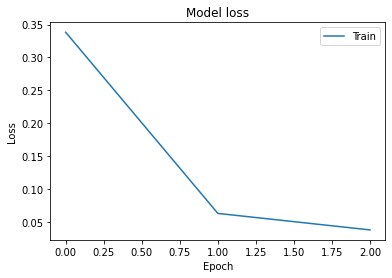

In [46]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

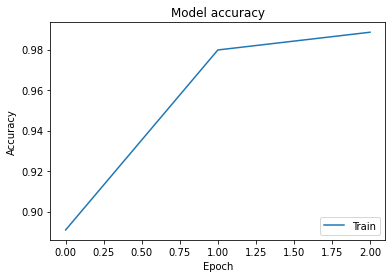

In [47]:
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='lower right')
plt.show()